In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim

In [50]:
print(torch.__version__)
print(torchvision.__version__)

1.5.1+cu101
0.6.1+cu101


In [51]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [52]:
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307),(0.309))] #mean and std of mnist
)

In [53]:
trainset=torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transf)

In [54]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=8,shuffle=True)

In [55]:
dataiter=iter(trainloader)
images,labels=dataiter.next()

print(images.shape)
print(images[1].shape)

torch.Size([8, 1, 28, 28])
torch.Size([1, 28, 28])


In [56]:
images.min(),images.max(),images.mean(),images.std()

(tensor(-0.4230), tensor(2.8133), tensor(-0.0892), tensor(0.8947))

In [57]:
def imshow(img):
    plt.figure(figsize=(10,5))
    std_correction = np.asarray([0.309]).reshape(1, 1, 1) #(3,1,1) in case of rgb
    mean_correction = np.asarray([0.1307]).reshape(1, 1, 1)
    npimg = np.multiply(img.cpu().detach().numpy(), std_correction) + mean_correction
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


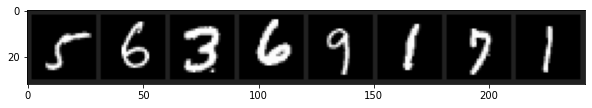

In [58]:
imshow(torchvision.utils.make_grid(images))

In [59]:
def add_noise(inputs,NOISE=0.4):
     noise = np.random.choice([0, 1], size=inputs.shape, p=[NOISE, 1 - NOISE])
     return inputs*torch.from_numpy(noise)

In [60]:
noisy_images = add_noise(images)
noisy_images.shape

torch.Size([8, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


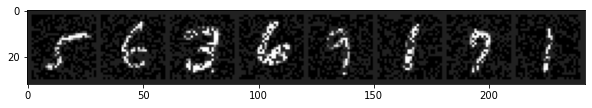

In [61]:
imshow(torchvision.utils.make_grid(noisy_images))

In [62]:
class AE(nn.Module):
    def __init__(self,hidden_size=128):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.05)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=28*28),
        )
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [63]:
batch_size = 128
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transf)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transf)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [64]:
hidden_size=150
net = AE(hidden_size=hidden_size).to(device)
loss_fn = nn.MSELoss()
opt = optim.Adam(net.parameters())

In [65]:
def evaluation(net,loader,device):
    net.eval()
    with torch.no_grad():
        total_loss=0
        for inputs,labels in loader:
            noisy_inputs = add_noise(inputs).to(device)
            inputs = inputs.to(device)
            input_features = inputs.view(inputs.size(0),-1)
            noisy_input_features = noisy_inputs.view(inputs.size(0),-1)
            outputs = net(noisy_input_features)
            loss = loss_fn(outputs,input_features)
            total_loss+=loss.item()
    return (total_loss/len(loader))



In [66]:
best_val=100

In [67]:
training_loss=[]
validation_loss=[]
num_epochs=25

for epoch in range(num_epochs):
    train_loss=0
    net.train()
    for inputs,labels in trainloader:
        noisy_inputs = add_noise(inputs).to(device)
        inputs = inputs.to(device)
        input_features = inputs.view(inputs.size(0),-1)
        noisy_input_features = noisy_inputs.view(inputs.size(0),-1)
        opt.zero_grad()
        outputs = net(noisy_input_features)
        loss = loss_fn(outputs,input_features)
        loss.backward()
        opt.step()
        train_loss+=loss.item()
    training_loss.append(loss)
    # training_loss.append(train_loss/len(trainloader))
    val_loss=evaluation(net,testloader,device)
    validation_loss.append(val_loss)
    if val_loss<best_val:
        torch.save(net.state_dict(),'my_ae.pt')
        best_val=val_loss
    print(f"Epoch {epoch+1}/{num_epochs} : Train Loss: {loss}, Val Loss: {val_loss}")
        

Epoch 1/25 : Train Loss: 0.2247401922941208, Val Loss: 0.18505387309985824
Epoch 2/25 : Train Loss: 0.19332225620746613, Val Loss: 0.17221119019049633
Epoch 3/25 : Train Loss: 0.19583292305469513, Val Loss: 0.16811844555637503
Epoch 4/25 : Train Loss: 0.19134165346622467, Val Loss: 0.16488713026046753
Epoch 5/25 : Train Loss: 0.18789884448051453, Val Loss: 0.16166174732431582
Epoch 6/25 : Train Loss: 0.17699551582336426, Val Loss: 0.16046569279477566
Epoch 7/25 : Train Loss: 0.17958100140094757, Val Loss: 0.1587289332211772
Epoch 8/25 : Train Loss: 0.19058290123939514, Val Loss: 0.15639880337292636
Epoch 9/25 : Train Loss: 0.1778942495584488, Val Loss: 0.15479471468472783
Epoch 10/25 : Train Loss: 0.17061065137386322, Val Loss: 0.15444992256315448
Epoch 11/25 : Train Loss: 0.17475874722003937, Val Loss: 0.1531429718944091
Epoch 12/25 : Train Loss: 0.17484840750694275, Val Loss: 0.15217471537710744
Epoch 13/25 : Train Loss: 0.17051701247692108, Val Loss: 0.15081622404388234
Epoch 14/25 

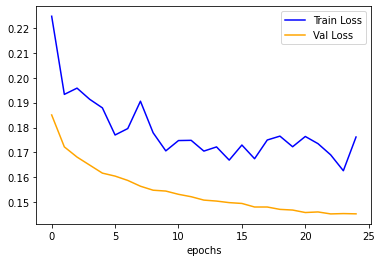

In [68]:

plt.plot(training_loss,label='Train Loss',color='blue')
plt.plot(validation_loss,label='Val Loss',color='orange')
plt.xlabel('epochs')
plt.legend()
plt.show()


In [69]:
testing_loader=torch.utils.data.DataLoader(testset,batch_size=8,shuffle=True)

In [70]:
dataiter=iter(testing_loader)
images,labels=dataiter.next()

print(images.shape)
print(images[1].shape)

torch.Size([8, 1, 28, 28])
torch.Size([1, 28, 28])


## Testing on un noisy images

In [71]:
net = AE(hidden_size=hidden_size).to(device)
net.load_state_dict(torch.load('my_ae.pt'))
net.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=150, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=150, out_features=784, bias=True)
  )
)

In [72]:
outputs = net(images.view(images.size(0),-1).to(device))
outputs.shape

torch.Size([8, 784])

In [73]:
outputs = outputs.view(8,1,28,28)
outputs.shape

torch.Size([8, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


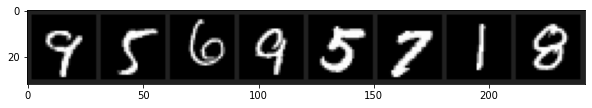

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


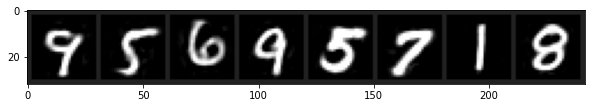

In [74]:
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(outputs))

## Testing on Noisy Images

In [75]:
noisy_images = add_noise(images)
noisy_images.shape

torch.Size([8, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


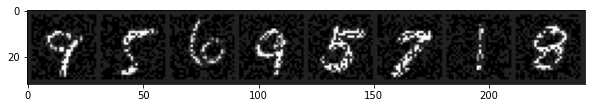

In [76]:
imshow(torchvision.utils.make_grid(noisy_images))

In [77]:
outputs = net(noisy_images.view(noisy_images.size(0),-1).to(device))
outputs.shape

torch.Size([8, 784])

In [78]:
outputs = outputs.view(8,1,28,28)
outputs.shape

torch.Size([8, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


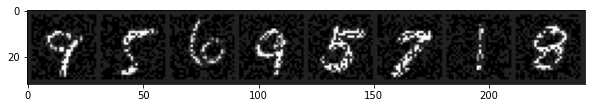

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


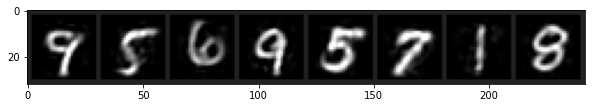

In [79]:
imshow(torchvision.utils.make_grid(noisy_images))
imshow(torchvision.utils.make_grid(outputs))

In [80]:
net.encoder[0].weight.data.shape

torch.Size([150, 784])

In [81]:
weights=net.encoder[0].weight.data

In [82]:
w1 = weights[0]
w1.shape

torch.Size([784])

## PLotting Weights

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


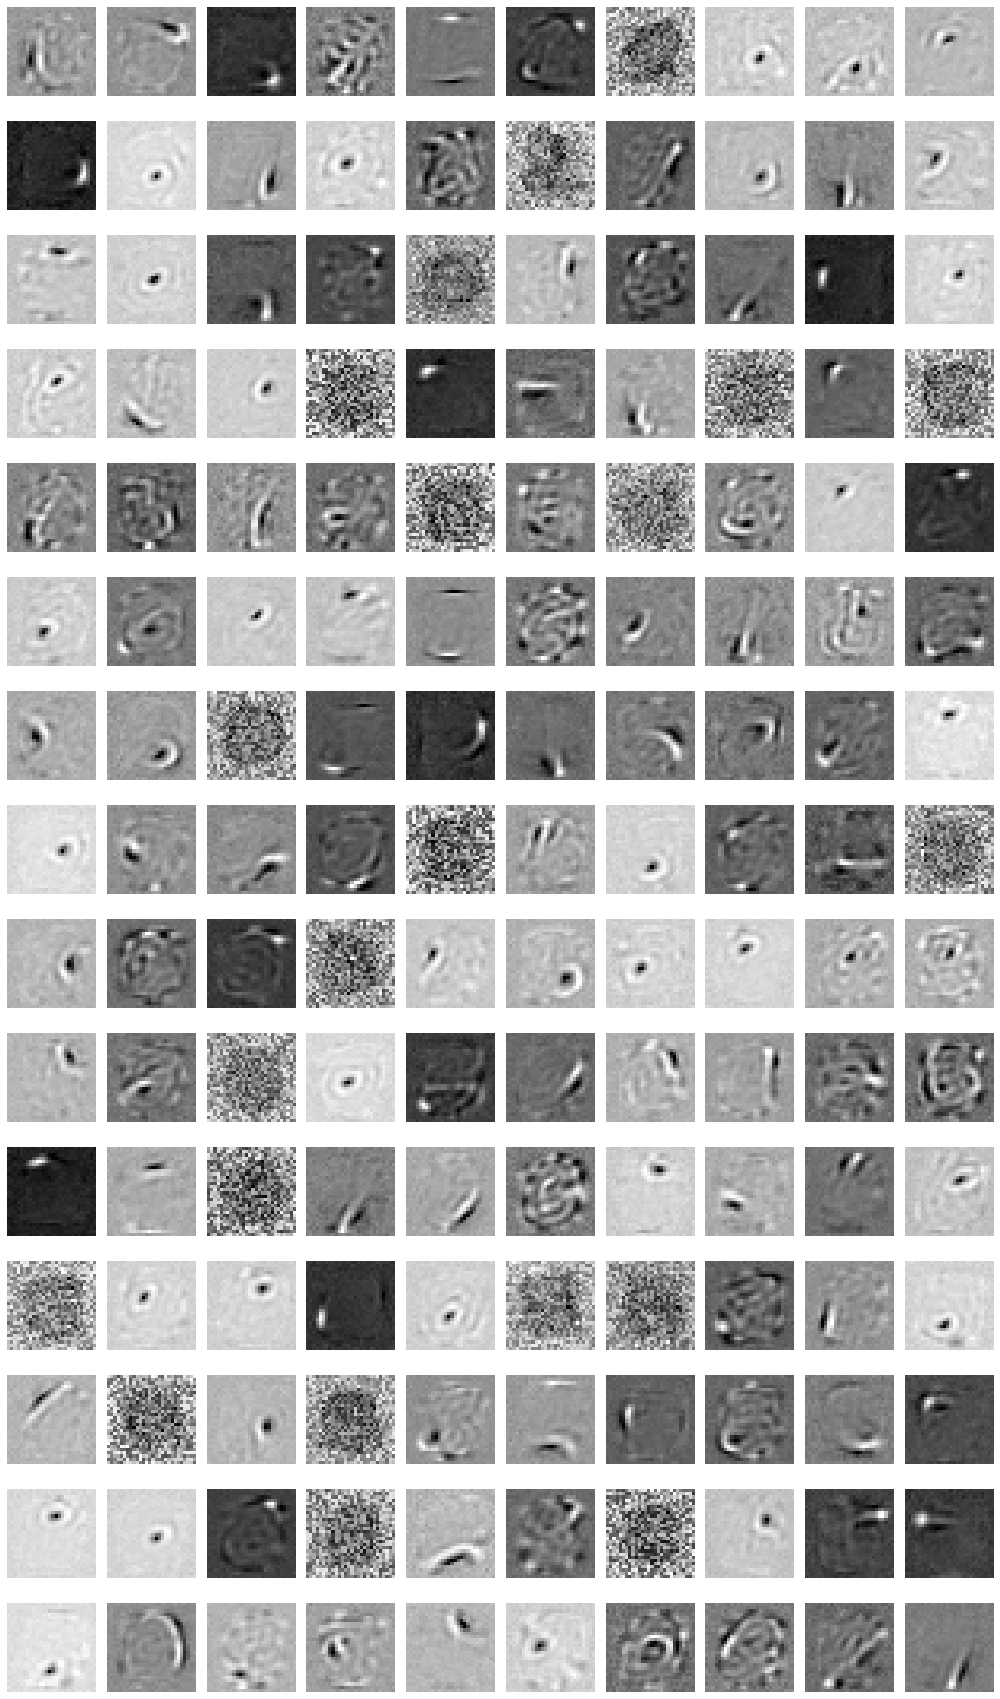

In [83]:
std_correction = np.asarray([0.309]).reshape(1, 1, 1) #(3,1,1) in case of rgb
mean_correction = np.asarray([0.1307]).reshape(1, 1, 1)

plt.figure(figsize=(14,24))
plt.subplot(15,10,1)
for i in range(150):
    ax1 = plt.subplot(15, 10, i+1)
    weight_id=i
    img=weights[weight_id].view(1,28,28)
    npimg = np.multiply(img.cpu().detach().numpy(), std_correction) + mean_correction
    plt.axis('off')
    # npimg = img.to('cpu').numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).reshape(28,28),cmap='gray')
plt.tight_layout()

plt.show()

In [84]:
784*1000 - (150*1000 + (784*150))

516400